# Detector de QR Codes Maliciosos

#### Alunos: Henrique Nastari Corrêa e Lucas Lopes
#### Orientador: Prof. Dr. Antonino Feitosa Neto

Projeto de detecção de QR Codes maliciosos utilizando Python e OpenCV válido como atividade avaliativa para disciplina de Processamento Digital de Imagens do curso de Tecnologia em Análise e Desenvolvimento de Sistemas da Universidade Federal do Rio Grande do Norte (UFRN).

##### AVISO IMPORTANTE: Todas as imagens de QR Codes utilizadas no projeto têm o objetivo de gerar os QR codes visualmente e ter o texto decodificado para análise no algoritmo, todos os exemplos de URLs de phishing simulado URLs Encurtadas e URLs com muitos parêmetros suspeitos são perfeitamente seguros. Os exemplos de tel: e smsto: também são seguros para geração e análise, desde que você não execute a ação sugerida pelo seu celular ao escanear.

##### Links dos QR Codes utilizados foram gerados pelo Gemini.

##### Importando bibliotecas necessárias:

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pyzbar.pyzbar as pyzbar
import cv2
import os

##### Exibir imagens de QR Codes que serão utilizados no projeto:

Exibindo QR Codes originais...


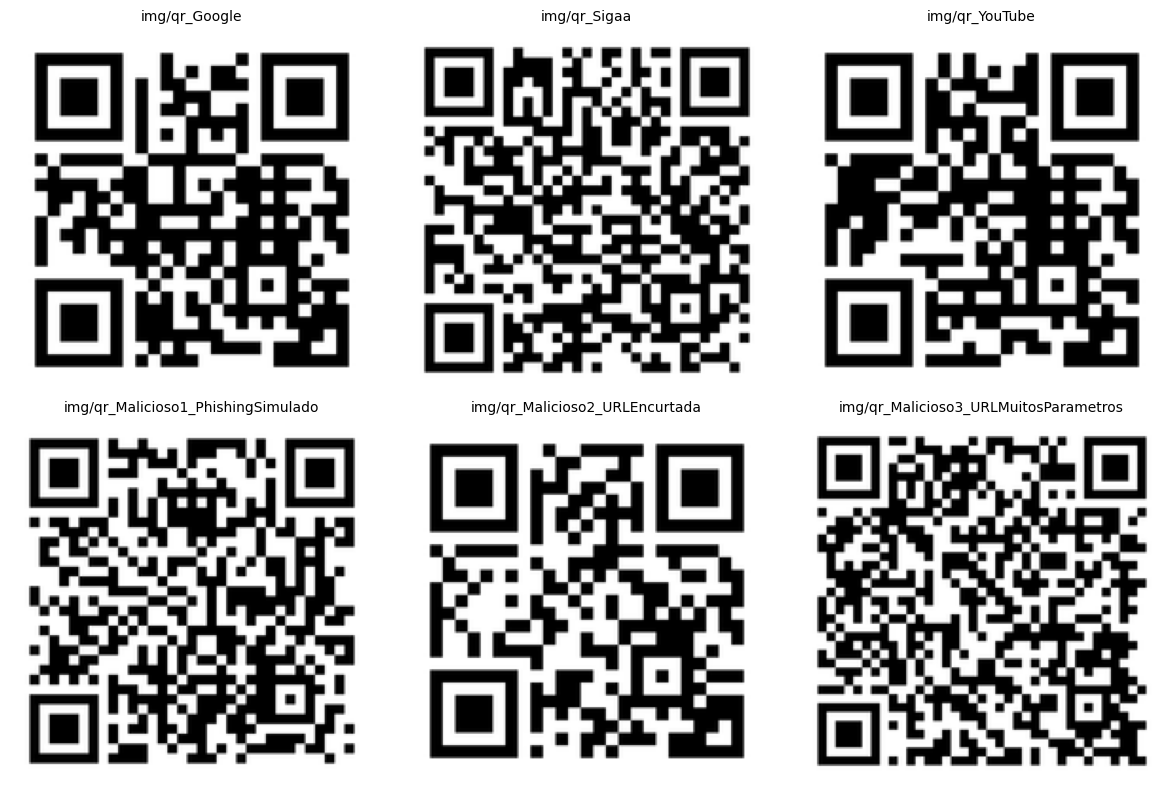


Exibição dos QR Codes originais concluída.


In [44]:
# --- Função para carregar a imagem (reutilizada) ---
def carregar_imagem(caminho_imagem):
    """
    Carrega uma imagem usando OpenCV.
    Retorna a imagem se for carregada com sucesso, caso contrário, None.
    """
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Aviso: Não foi possível carregar a imagem em: {caminho_imagem}. Verifique o caminho ou o formato do arquivo.")
            return None
        return img
    except Exception as e:
        print(f"Erro inesperado ao carregar a imagem {caminho_imagem}: {e}")
        return None

# --- Lista de caminhos para os seus 6 QR Codes ---
# Por favor, verifique se estes nomes correspondem exatamente aos nomes dos seus arquivos.
# Recomenda-se que estejam no mesmo diretório do seu Jupyter Notebook.
caminhos_qr_codes = [
    "img/qr_Google.png",
    "img/qr_Sigaa.png",
    "img/qr_YouTube.png",
    "img/qr_Malicioso1_PhishingSimulado.png",
    "img/qr_Malicioso2_URLEncurtada.png",
    "img/qr_Malicioso3_URLMuitosParametros.png"
]

# --- Configurações da Grade ---
# Queremos exibir os 6 QR Codes. Podemos usar 3 colunas para ter 2 linhas.
num_colunas = 3
num_linhas = (len(caminhos_qr_codes) + num_colunas - 1) // num_colunas # Calcula o número de linhas necessário

plt.figure(figsize=(num_colunas * 4, num_linhas * 4)) # Ajusta o tamanho da figura (4 polegadas por imagem)

print("Exibindo QR Codes originais...")

for i, caminho in enumerate(caminhos_qr_codes):
    imagem_qr = carregar_imagem(caminho)

    # Adiciona um subplot na posição correta da grade
    plt.subplot(num_linhas, num_colunas, i + 1)

    if imagem_qr is not None:
        # OpenCV lê em BGR, Matplotlib espera RGB. É crucial fazer essa conversão.
        imagem_qr_rgb = cv2.cvtColor(imagem_qr, cv2.COLOR_BGR2RGB)
        plt.imshow(imagem_qr_rgb)
        plt.title(f"{caminho.replace('.png', '')}", fontsize=10) # Título com nome do arquivo sem a extensão
        plt.axis('off') # Remove os eixos para uma visualização mais limpa
    else:
        # Se a imagem não carregar, plota um placeholder e um aviso
        plt.text(0.5, 0.5, "ERRO\nIMAGEM NÃO CARREGADA",
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, color='red', fontsize=10)
        plt.title(f"Falha: {caminho}", fontsize=10)
        plt.axis('off')

plt.tight_layout() # Ajusta o layout para evitar sobreposição de títulos/imagens
plt.show()

print("\nExibição dos QR Codes originais concluída.")

##### Geração de ruídos para simulação de imagens de QR Codes com problemas de visualização:

Pasta 'imagens_ruidosas/' já existe.

Gerando imagens com ruído e salvando em pasta...
Salvo: imagens_ruidosas/qr_Google_ruido_Gaussiano.png
Salvo: imagens_ruidosas/qr_Sigaa_ruido_Sal e Pimenta.png
Salvo: imagens_ruidosas/qr_YouTube_ruido_Sombreamento.png
Salvo: imagens_ruidosas/qr_Malicioso1_PhishingSimulado_ruido_Gaussiano.png
Salvo: imagens_ruidosas/qr_Malicioso2_URLEncurtada_ruido_Sal e Pimenta.png
Salvo: imagens_ruidosas/qr_Malicioso3_URLMuitosParametros_ruido_Sombreamento.png

Exibindo imagens com ruído gerado (e salvas):


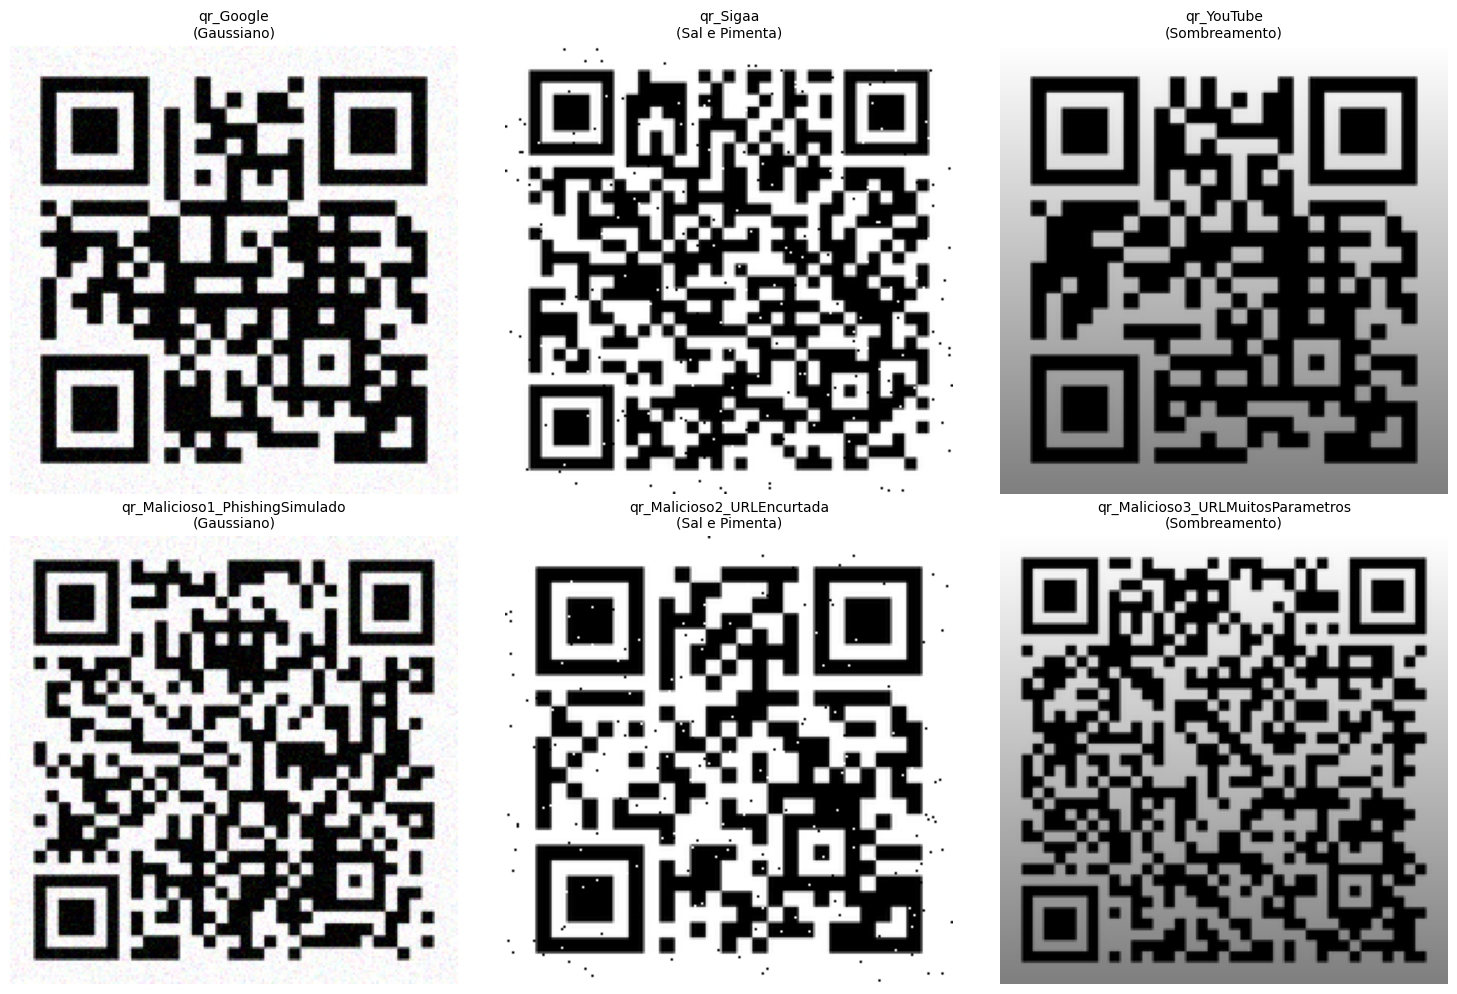


Processamento de ruído e salvamento concluídos.


In [50]:
# --- Funções de Carregamento (Reutilizada) ---
def carregar_imagem(caminho_imagem):
    """
    Carrega uma imagem usando OpenCV.
    Retorna a imagem se for carregada com sucesso, caso contrário, None.
    """
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Aviso: Não foi possível carregar a imagem em: {caminho_imagem}. Verifique o caminho ou o formato do arquivo.")
            return None
        return img
    except Exception as e:
        print(f"Erro inesperado ao carregar a imagem {caminho_imagem}: {e}")
        return None

# --- Funções de ADIÇÃO de Ruído (Parâmetros ajustados para serem visíveis mas tratáveis) ---
def adicionar_ruido_gaussiano(imagem, media=0, variancia=150):
    row, col, ch = imagem.shape
    sigma = variancia**0.5
    gauss = np.random.normal(media, sigma, (row, col, ch))
    noisy_image = imagem.astype(np.float32) + gauss
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def adicionar_ruido_sal_pimenta(imagem, densidade=0.01):
    output = np.copy(imagem)
    total_pixels = imagem.shape[0] * imagem.shape[1]

    num_salt = int(np.ceil(densidade * total_pixels * 0.5))
    coords_salt = np.random.randint(0, [imagem.shape[0], imagem.shape[1]], size=(num_salt, 2))
    for x, y in coords_salt:
        output[x, y, :] = 255

    num_pepper = int(np.ceil(densidade * total_pixels * 0.5))
    coords_pepper = np.random.randint(0, [imagem.shape[0], imagem.shape[1]], size=(num_pepper, 2))
    for x, y in coords_pepper:
        output[x, y, :] = 0

    return output

def simular_sombreamento(imagem, intensidade_min=0.5, intensidade_max=1.0):
    h, w, _ = imagem.shape
    sombra_map = np.linspace(intensidade_max, intensidade_min, h, dtype=np.float32)
    sombra_map = np.tile(sombra_map.reshape(-1, 1), (1, w))

    sombra_map_3ch = np.stack([sombra_map, sombra_map, sombra_map], axis=-1)
    shaded_image = imagem.astype(np.float32) * sombra_map_3ch
    return np.clip(shaded_image, 0, 255).astype(np.uint8)


# --- Configurações de Caminho ---
# Pasta onde os QR Codes originais estão. Ajuste se necessário.
PASTA_ORIGINAIS = "img/"
# Pasta onde as imagens com ruído serão salvas.
PASTA_RUIDOSAS = "imagens_ruidosas/"

# Lista de nomes de arquivos dos QR Codes (sem o prefixo da pasta)
nomes_qr_codes = [
    "qr_Google.png",
    "qr_Sigaa.png",
    "qr_YouTube.png", # Corrigido se tiver extensao .2
    "qr_Malicioso1_PhishingSimulado.png",
    "qr_Malicioso2_URLEncurtada.png",
    "qr_Malicioso3_URLMuitosParametros.png"
]

# --- Cria a pasta para as imagens ruidosas, se não existir ---
if not os.path.exists(PASTA_RUIDOSAS):
    os.makedirs(PASTA_RUIDOSAS)
    print(f"Pasta '{PASTA_RUIDOSAS}' criada com sucesso.")
else:
    print(f"Pasta '{PASTA_RUIDOSAS}' já existe.")

# Lista para armazenar as imagens com ruído para exibição e salvamento
imagens_com_ruido_para_salvar = []
titulos_imagens_com_ruido_para_salvar = []

print("\nGerando imagens com ruído e salvando em pasta...")

for i, nome_arquivo in enumerate(nomes_qr_codes):
    caminho_original = os.path.join(PASTA_ORIGINAIS, nome_arquivo)
    imagem_original = carregar_imagem(caminho_original)

    if imagem_original is not None:
        imagem_ruidosa = None
        tipo_ruido = ""

        # Aplica um tipo de ruído diferente a cada imagem, ciclando entre 3 tipos
        if i % 3 == 0:
            imagem_ruidosa = adicionar_ruido_gaussiano(imagem_original.copy())
            tipo_ruido = "Gaussiano"
        elif i % 3 == 1:
            imagem_ruidosa = adicionar_ruido_sal_pimenta(imagem_original.copy())
            tipo_ruido = "Sal e Pimenta"
        else:
            imagem_ruidosa = simular_sombreamento(imagem_original.copy())
            tipo_ruido = "Sombreamento"

        # Salva a imagem ruidosa na pasta PASTA_RUIDOSAS
        nome_arquivo_ruidoso = f"{os.path.splitext(nome_arquivo)[0]}_ruido_{tipo_ruido}.png"
        caminho_salvamento = os.path.join(PASTA_RUIDOSAS, nome_arquivo_ruidoso)

        cv2.imwrite(caminho_salvamento, imagem_ruidosa)
        print(f"Salvo: {caminho_salvamento}")

        imagens_com_ruido_para_salvar.append(imagem_ruidosa)
        titulos_imagens_com_ruido_para_salvar.append(f"{os.path.splitext(nome_arquivo)[0]}\n({tipo_ruido})")
    else:
        print(f"Não foi possível carregar a imagem original {caminho_original}. Pulando.")
        imagens_com_ruido_para_salvar.append(np.zeros((100, 100, 3), dtype=np.uint8))
        titulos_imagens_com_ruido_para_salvar.append(f"Erro: {os.path.splitext(nome_arquivo)[0]}")

# --- Plotar apenas as imagens com ruído em grade ---
num_colunas_plot = 3
num_linhas_plot = (len(imagens_com_ruido_para_salvar) + num_colunas_plot - 1) // num_colunas_plot

plt.figure(figsize=(num_colunas_plot * 5, num_linhas_plot * 5))

print("\nExibindo imagens com ruído gerado (e salvas):")

for i, img_ruidosa in enumerate(imagens_com_ruido_para_salvar):
    plt.subplot(num_linhas_plot, num_colunas_plot, i + 1)
    plt.imshow(cv2.cvtColor(img_ruidosa, cv2.COLOR_BGR2RGB))
    plt.title(titulos_imagens_com_ruido_para_salvar[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nProcessamento de ruído e salvamento concluídos.")

##### Tratamento de imagem dos QR Codes para remoção de ruídos:

Carregando imagens ruidosas e aplicando pré-processamento...
Pré-processando: qr_Google_ruido_Gaussiano.png
Pré-processando: qr_Malicioso1_PhishingSimulado_ruido_Gaussiano.png
Pré-processando: qr_Malicioso2_URLEncurtada_ruido_Sal e Pimenta.png
Pré-processando: qr_Malicioso3_URLMuitosParametros_ruido_Sombreamento.png
Pré-processando: qr_Sigaa_ruido_Sal e Pimenta.png
Pré-processando: qr_YouTube_ruido_Sombreamento.png

Exibindo imagens pré-processadas:


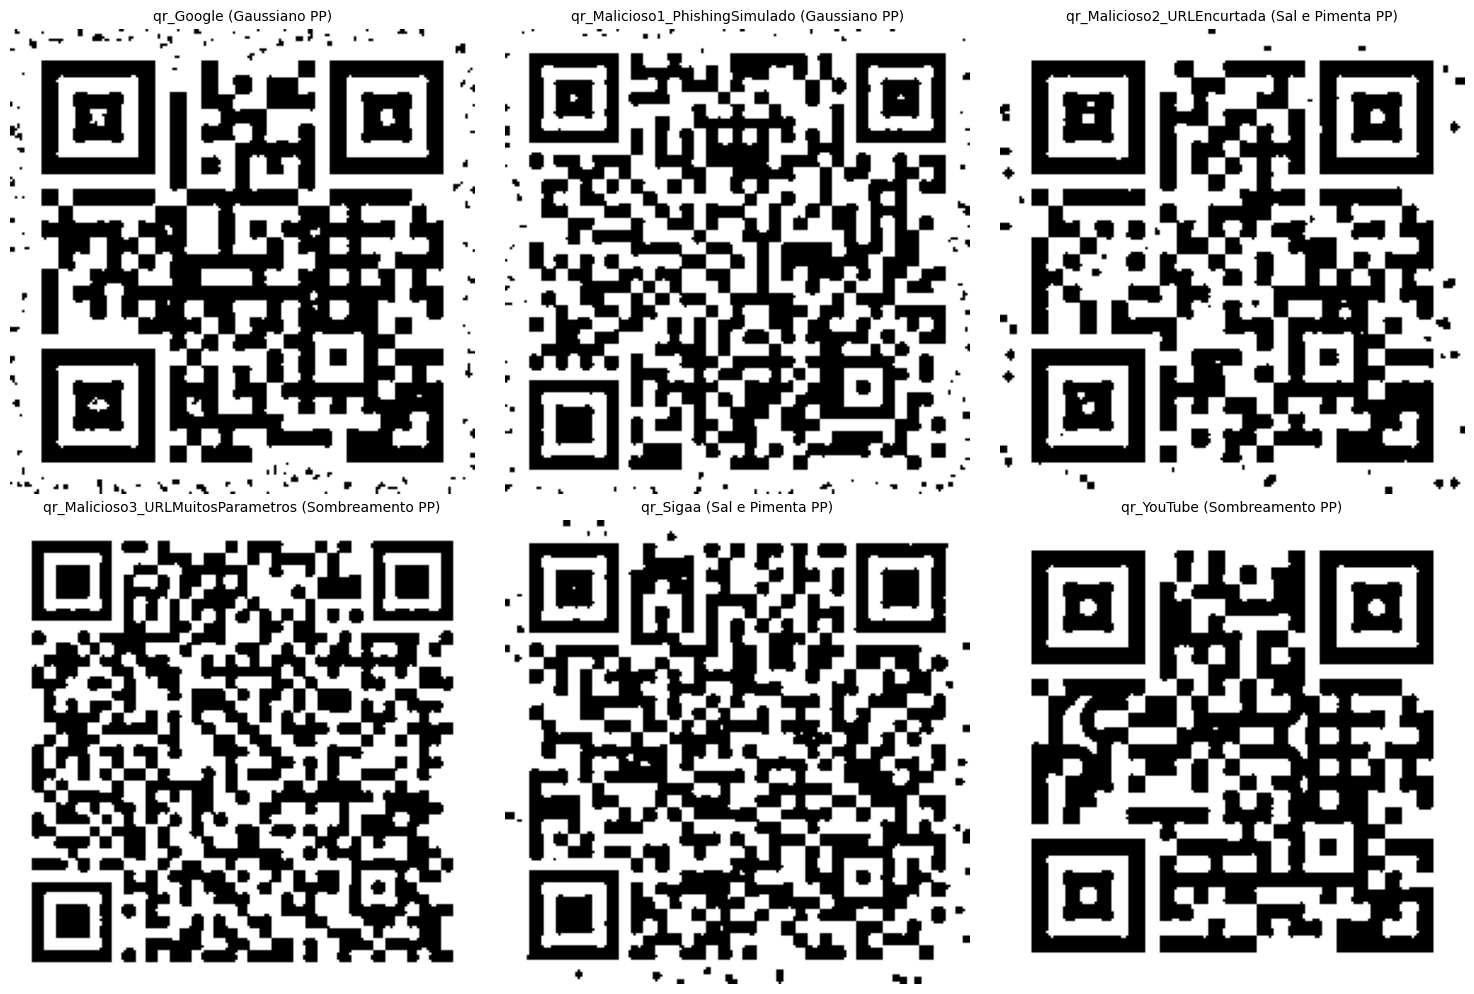


Exibição das imagens pré-processadas concluída. Marco 1 avaliado.


In [51]:
# --- Funções de Carregamento (Reutilizada) ---
def carregar_imagem(caminho_imagem):
    """
    Carrega uma imagem usando OpenCV.
    Retorna a imagem se for carregada com sucesso, caso contrário, None.
    """
    try:
        img = cv2.imread(caminho_imagem)
        if img is None:
            print(f"Aviso: Não foi possível carregar a imagem em: {caminho_imagem}. Verifique o caminho ou o formato do arquivo.")
            return None
        return img
    except Exception as e:
        print(f"Erro inesperado ao carregar a imagem {caminho_imagem}: {e}")
        return None

# --- FUNÇÃO PRINCIPAL DE PRÉ-PROCESSAMENTO PARA QR CODES (Otimizada) ---
def pre_processar_qr_code(imagem_input):
    """
    Aplica um pipeline de pré-processamento otimizado para QR Codes:
    1. Converte para escala de cinza.
    2. Aplica filtro Gaussiano leve para suavização.
    3. Aplica binarização adaptativa para realçar o contraste e bordas.
    """
    # 1. Converte para escala de cinza
    img_gray = cv2.cvtColor(imagem_input, cv2.COLOR_BGR2GRAY)

    # 2. Aplica um filtro Gaussiano suave para remover pequenos ruídos e suavizar.
    # Isso ajuda a binarização adaptativa a ter um resultado mais uniforme.
    img_blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # 3. Aplica Binarização Adaptativa
    # cv2.ADAPTIVE_THRESH_GAUSSIAN_C: o limiar é uma soma ponderada gaussiana dos valores de vizinhança.
    # cv2.THRESH_BINARY: o tipo de limiarização (resultado binário: 0 ou 255).
    # 255: O valor máximo para o pixel no resultado binarizado.
    # BLOCK_SIZE: Tamanho da vizinhança (deve ser ímpar, maior para áreas maiores).
    # C: Constante subtraída da média ou soma ponderada calculada (negativo para mais preto, positivo para mais branco).
    img_binarized = cv2.adaptiveThreshold(img_blurred, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 15, 2) # Aumentei BLOCK_SIZE para 15 para melhor adaptação

    # Para exibição, converte a imagem binarizada de volta para BGR (3 canais)
    return cv2.cvtColor(img_binarized, cv2.COLOR_GRAY2BGR)


# --- Configurações de Caminho ---
# Pasta onde as imagens ruidosas foram salvas na Célula 3.
PASTA_RUIDOSAS = "imagens_ruidosas/"

# Lista para armazenar as imagens pré-processadas e seus títulos para exibição
imagens_pre_processadas = []
titulos_imagens_pre_processadas = []

print("Carregando imagens ruidosas e aplicando pré-processamento...")

# Lista todos os arquivos .png na pasta de imagens ruidosas
arquivos_ruidosos = [f for f in os.listdir(PASTA_RUIDOSAS) if f.endswith('.png')]
arquivos_ruidosos.sort() # Garante uma ordem consistente de exibição

for nome_arquivo_ruidoso in arquivos_ruidosos:
    caminho_ruidoso = os.path.join(PASTA_RUIDOSAS, nome_arquivo_ruidoso)
    imagem_ruidosa = carregar_imagem(caminho_ruidoso)

    if imagem_ruidosa is not None:
        print(f"Pré-processando: {nome_arquivo_ruidoso}")
        # Aplica o pipeline de pré-processamento
        imagem_final_processada = pre_processar_qr_code(imagem_ruidosa.copy())

        imagens_pre_processadas.append(imagem_final_processada)

        # Gera o título a partir do nome do arquivo (ex: "qr_Google_ruido_Gaussiano" -> "qr_Google (Gaussiano PP)")
        titulo_limpo = nome_arquivo_ruidoso.replace('.png', '').replace('_ruido_', ' (') + ' PP)'
        titulos_imagens_pre_processadas.append(titulo_limpo)
    else:
        print(f"Não foi possível carregar a imagem ruidosa {caminho_ruidoso}. Pulando.")
        # Adiciona placeholders para manter o layout da grade em caso de erro
        imagens_pre_processadas.append(np.zeros((100, 100, 3), dtype=np.uint8))
        titulos_imagens_pre_processadas.append(f"Erro: {nome_arquivo_ruidoso}")


# --- Plotar apenas as imagens pré-processadas em grade ---
num_colunas_plot = 3
num_linhas_plot = (len(imagens_pre_processadas) + num_colunas_plot - 1) // num_colunas_plot

plt.figure(figsize=(num_colunas_plot * 5, num_linhas_plot * 5))

print("\nExibindo imagens pré-processadas:")

for i, img_pp in enumerate(imagens_pre_processadas):
    plt.subplot(num_linhas_plot, num_colunas_plot, i + 1)
    plt.imshow(cv2.cvtColor(img_pp, cv2.COLOR_BGR2RGB)) # Converter para RGB para exibição
    plt.title(titulos_imagens_pre_processadas[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\nExibição das imagens pré-processadas concluída. Marco 1 avaliado.")

##### Função para detecção de QR Codes:

##### Função para verificar se o QR Code é malicioso:

##### Função para exibir os resultados da análise do QR Code: